In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import random

data = pd.read_csv("xgboost_data.csv")

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Configuration
TARGET_VARIABLE = 'PCT_PRICE_CHANGE_DETRENDED (%)'
RAW_TARGET_VARIABLE = 'PCT_PRICE_CHANGE (%)'
YEAR_COLUMN = 'YEAR'
ZIP_COLUMN = 'ZIP_CODE'
TRAIN_YEAR_CUTOFF = 2020

# XGBoost specific params (can be tuned later)
XGB_PARAMS = {
    'objective': 'reg:squarederror', # Objective function for regression
    'n_estimators': 100,            # Number of boosting rounds/trees
    'learning_rate': 0.1,           # Step size shrinkage
    'max_depth': 5,                 # Maximum tree depth
    'subsample': 0.8,               # Fraction of samples used per tree
    'colsample_bytree': 0.8,        # Fraction of features used per tree
    'random_state': 42,
    'n_jobs': -1                    # Use all available CPU cores
}

In [2]:
# Step 1: Detrending Target Variable
print("--- Detrending Target Variable ---")
# Ensure YEAR is numeric
data[YEAR_COLUMN] = pd.to_numeric(data[YEAR_COLUMN], errors='coerce')
data = data.dropna(subset=[YEAR_COLUMN, RAW_TARGET_VARIABLE]) # Drop rows where year or target is missing

trend_model = LinearRegression()
# Reshape YEAR for sklearn compatibility
trend_model.fit(data[[YEAR_COLUMN]], data[RAW_TARGET_VARIABLE])
predicted_trend = trend_model.predict(data[[YEAR_COLUMN]])
data[TARGET_VARIABLE] = data[RAW_TARGET_VARIABLE] - predicted_trend
print(f"Target variable '{TARGET_VARIABLE}' created.")
print(f"Target variable mean: {data[TARGET_VARIABLE].mean():.4f}, std: {data[TARGET_VARIABLE].std():.4f}")


--- Detrending Target Variable ---
Target variable 'PCT_PRICE_CHANGE_DETRENDED (%)' created.
Target variable mean: 0.0000, std: 10.9982


In [3]:
# Step 2: Define Feature Sets
print("\n--- Defining Feature Sets ---")
# Carefully select features, avoiding leakage from future/target variables
baseline_features = [
    'Median_Household_Income', 'Total_Population', 'Avg_Household_Size',
    'Gini_Index', 'Employment_Rate', 'Below_Poverty_Rate',
    'Rate_College_or_Higher', 'Black_Portion', 'White_Portion',
    'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion',
    # Lagged Price Features
    'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1', 'PRICE_CHANGE_DIFF',
    'ROLLING_1yr_PRICE_CHANGE', 'ROLLING_3yr_PRICE_CHANGE_STD'
    # Avoid interaction terms involving FIRE here
]

wildfire_features = [
    'NUM_FIRES', 'TOTAL_ACRES_BURNED_IN_ZIP', 'AVG_FIRE_DURATION_DAYS',
    'MAX_PCT_ZIP_BURNED', 'ANY_MAJOR_FIRE', 'FIRE_EXPOSED',
    'PREV_MAX_PCT_ZIP_BURNED', 'FIRE_LAST_YEAR', 'FIRE_SHOCK',
    'YEARS_SINCE_LAST_FIRE', 'CUMULATIVE_ACRES_BURNED_LAST_3YRS',
    # Interaction terms
    'FIRE_EXPOSED_x_PRICE_CHANGE_LAG1',
    'MAX_PCT_ZIP_BURNED_x_ROLLING_1yr_PRICE_CHANGE',
    'FIRE_EXPOSED_x_Median_Household_Income',
    'FIRE_EXPOSED_x_Below_Poverty_Rate'
]

# Ensure all defined features exist in the dataframe columns
baseline_features = [f for f in baseline_features if f in data.columns]
wildfire_features = [f for f in wildfire_features if f in data.columns]

# Combine for the second model
all_features = list(set(baseline_features + wildfire_features))

# Verify no target/future leakage in feature lists
leaky_features = ['PRICE', 'NEXT_YEAR_PRICE', 'PRICE_CHANGE', RAW_TARGET_VARIABLE, TARGET_VARIABLE]
for f in leaky_features:
    if f in baseline_features: print(f"Warning: Potentially leaky feature '{f}' in baseline_features")
    if f in wildfire_features: print(f"Warning: Potentially leaky feature '{f}' in wildfire_features")

print(f"Using Baseline Features ({len(baseline_features)}): {baseline_features}")
print(f"Using Wildfire Features ({len(wildfire_features)}): {wildfire_features}")
print(f"Using All Features ({len(all_features)}): {all_features}")

# Ensure target variable is not in features
if TARGET_VARIABLE in all_features:
    all_features.remove(TARGET_VARIABLE)
    print(f"Warning: Removed target variable '{TARGET_VARIABLE}' from feature list.")
if TARGET_VARIABLE in baseline_features:
    baseline_features.remove(TARGET_VARIABLE)
    print(f"Warning: Removed target variable '{TARGET_VARIABLE}' from baseline feature list.")


--- Defining Feature Sets ---
Using Baseline Features (16): ['Median_Household_Income', 'Total_Population', 'Avg_Household_Size', 'Gini_Index', 'Employment_Rate', 'Below_Poverty_Rate', 'Rate_College_or_Higher', 'Black_Portion', 'White_Portion', 'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion', 'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1', 'PRICE_CHANGE_DIFF', 'ROLLING_1yr_PRICE_CHANGE', 'ROLLING_3yr_PRICE_CHANGE_STD']
Using Wildfire Features (15): ['NUM_FIRES', 'TOTAL_ACRES_BURNED_IN_ZIP', 'AVG_FIRE_DURATION_DAYS', 'MAX_PCT_ZIP_BURNED', 'ANY_MAJOR_FIRE', 'FIRE_EXPOSED', 'PREV_MAX_PCT_ZIP_BURNED', 'FIRE_LAST_YEAR', 'FIRE_SHOCK', 'YEARS_SINCE_LAST_FIRE', 'CUMULATIVE_ACRES_BURNED_LAST_3YRS', 'FIRE_EXPOSED_x_PRICE_CHANGE_LAG1', 'MAX_PCT_ZIP_BURNED_x_ROLLING_1yr_PRICE_CHANGE', 'FIRE_EXPOSED_x_Median_Household_Income', 'FIRE_EXPOSED_x_Below_Poverty_Rate']
Using All Features (31): ['NUM_FIRES', 'Median_Household_Income', 'ANY_MAJOR_FIRE', 'CUMULATIVE_ACRES_BURNED_LAST_3YRS', 'HOME_PRIC

In [4]:
# Step 3: Sort Data and Temporal Split
print(f"\n--- Splitting Data: Train <= {TRAIN_YEAR_CUTOFF}, Test > {TRAIN_YEAR_CUTOFF} ---")
data = data.sort_values(by=[YEAR_COLUMN, ZIP_COLUMN]).reset_index(drop=True)

train_data = data[data[YEAR_COLUMN] <= TRAIN_YEAR_CUTOFF].copy()
test_data = data[data[YEAR_COLUMN] > TRAIN_YEAR_CUTOFF].copy()

# --- Check ---
if train_data.empty or test_data.empty:
    raise ValueError(f"Train or test split resulted in empty DataFrame. "
                     f"Check TRAIN_YEAR_CUTOFF ({TRAIN_YEAR_CUTOFF}) and data range "
                     f"({data[YEAR_COLUMN].min()}-{data[YEAR_COLUMN].max()}).")

if train_data[YEAR_COLUMN].max() >= test_data[YEAR_COLUMN].min():
     print(f"Warning: Potential overlap or issue in year split logic. "
           f"Max train year: {train_data[YEAR_COLUMN].max()}, Min test year: {test_data[YEAR_COLUMN].min()}")


print(f"Train data shape: {train_data.shape}")
print(f"Test data shape:  {test_data.shape}")
print(f"Train years: {train_data[YEAR_COLUMN].min()} - {train_data[YEAR_COLUMN].max()}")
print(f"Test years:  {test_data[YEAR_COLUMN].min()} - {test_data[YEAR_COLUMN].max()}")

# Separate features (X) and target (y) for both sets
y_train = train_data[TARGET_VARIABLE]
y_test = test_data[TARGET_VARIABLE]

X_train_base = train_data[baseline_features]
X_test_base = test_data[baseline_features]

X_train_wf = train_data[all_features]
X_test_wf = test_data[all_features]


--- Splitting Data: Train <= 2020, Test > 2020 ---
Train data shape: (15667, 39)
Test data shape:  (2750, 39)
Train years: 2012 - 2020
Test years:  2021 - 2021


In [5]:
# Step 4: Imputation and Scaling
print("\n--- Applying Imputation and Scaling ---")

# --- Imputation ---
# Fit Imputer ONLY on training data, then transform both train and test
imputer_base = SimpleImputer(strategy='median')
X_train_base_imputed = imputer_base.fit_transform(X_train_base)
X_test_base_imputed = imputer_base.transform(X_test_base)
print(f"Imputed NaNs in Baseline features using median strategy.")

imputer_wf = SimpleImputer(strategy='median')
X_train_wf_imputed = imputer_wf.fit_transform(X_train_wf)
X_test_wf_imputed = imputer_wf.transform(X_test_wf)
print(f"Imputed NaNs in All features using median strategy.")

# --- Scaling ---
# Fit Scaler ONLY on training data, then transform both train and test
scaler_base = StandardScaler()
X_train_base_scaled = scaler_base.fit_transform(X_train_base_imputed)
X_test_base_scaled = scaler_base.transform(X_test_base_imputed)
print(f"Scaled Baseline features using StandardScaler.")

scaler_wf = StandardScaler()
X_train_wf_scaled = scaler_wf.fit_transform(X_train_wf_imputed)
X_test_wf_scaled = scaler_wf.transform(X_test_wf_imputed)
print(f"Scaled All features using StandardScaler.")

# Convert back to DataFrames (maintains column names for importance plots)
X_train_base_scaled = pd.DataFrame(X_train_base_scaled, columns=baseline_features, index=X_train_base.index)
X_test_base_scaled = pd.DataFrame(X_test_base_scaled, columns=baseline_features, index=X_test_base.index)
X_train_wf_scaled = pd.DataFrame(X_train_wf_scaled, columns=all_features, index=X_train_wf.index)
X_test_wf_scaled = pd.DataFrame(X_test_wf_scaled, columns=all_features, index=X_test_wf.index)

print("Imputation and Scaling complete.")


--- Applying Imputation and Scaling ---
Imputed NaNs in Baseline features using median strategy.
Imputed NaNs in All features using median strategy.
Scaled Baseline features using StandardScaler.
Scaled All features using StandardScaler.
Imputation and Scaling complete.


In [6]:
# Step 5: Model Training
print("\n--- Training Models ---")

# --- Linear Regression ---
lr_base = LinearRegression()
lr_base.fit(X_train_base_scaled, y_train)
print("Trained Linear Regression (Baseline).")

lr_wf = LinearRegression()
lr_wf.fit(X_train_wf_scaled, y_train)
print("Trained Linear Regression (Wildfire Features).")

# --- Random Forest ---
# Using basic parameters; consider tuning these
rf_base = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_leaf=5)
rf_base.fit(X_train_base_scaled, y_train)
print("Trained Random Forest (Baseline).")

rf_wf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_leaf=5)
rf_wf.fit(X_train_wf_scaled, y_train)
print("Trained Random Forest (Wildfire Features).")

# --- XGBoost ---
xgb_base = XGBRegressor(**XGB_PARAMS)
xgb_base.fit(X_train_base_scaled, y_train)
print("Trained XGBoost (Baseline).")

xgb_wf = XGBRegressor(**XGB_PARAMS)
xgb_wf.fit(X_train_wf_scaled, y_train)
print("Trained XGBoost (Wildfire Features).")


--- Training Models ---
Trained Linear Regression (Baseline).
Trained Linear Regression (Wildfire Features).
Trained Random Forest (Baseline).
Trained Random Forest (Wildfire Features).
Trained XGBoost (Baseline).
Trained XGBoost (Wildfire Features).


In [7]:
# Step 6: Evaluation on Test Set
print("\n--- Evaluating Models on Test Set ---")

results = {}
predictions = {}

models_to_evaluate = {
    "Linear Regression (Baseline)": (lr_base, X_test_base_scaled),
    "Linear Regression (Wildfire)": (lr_wf, X_test_wf_scaled),
    "Random Forest (Baseline)": (rf_base, X_test_base_scaled),
    "Random Forest (Wildfire)": (rf_wf, X_test_wf_scaled),
    "XGBoost (Baseline)": (xgb_base, X_test_base_scaled),
    "XGBoost (Wildfire)": (xgb_wf, X_test_wf_scaled)
}

for name, (model, X_test_data) in models_to_evaluate.items():
    y_pred = model.predict(X_test_data)
    predictions[name] = y_pred
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    print(f"\n--- {name} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R2:   {r2:.4f} <<< Realistic performance estimate") 


--- Evaluating Models on Test Set ---

--- Linear Regression (Baseline) ---
RMSE: 9.5161
MAE:  6.3057
R2:   0.2925 <<< Realistic performance estimate

--- Linear Regression (Wildfire) ---
RMSE: 9.5237
MAE:  6.3186
R2:   0.2913 <<< Realistic performance estimate

--- Random Forest (Baseline) ---
RMSE: 6.0169
MAE:  4.5565
R2:   0.7171 <<< Realistic performance estimate

--- Random Forest (Wildfire) ---
RMSE: 6.0213
MAE:  4.5581
R2:   0.7167 <<< Realistic performance estimate

--- XGBoost (Baseline) ---
RMSE: 5.4872
MAE:  3.6159
R2:   0.7648 <<< Realistic performance estimate

--- XGBoost (Wildfire) ---
RMSE: 5.4510
MAE:  3.6069
R2:   0.7678 <<< Realistic performance estimate


In [8]:
# Step 7: Compare Results Summary
print("\n--- Comparison Summary (Test Set Performance) ---")
results_df = pd.DataFrame(results).T # Transpose for better readability
print(results_df.sort_values(by='R2', ascending=False)) # Sort by R2 score

# Explicit R2 comparisons
print("\n--- R2 Improvement from Wildfire Features ---")
for model_type in ["Linear Regression", "Random Forest", "XGBoost"]:
    base_name = f"{model_type} (Baseline)"
    wf_name = f"{model_type} (Wildfire)"
    if base_name in results and wf_name in results:
        base_r2 = results[base_name]["R2"]
        wf_r2 = results[wf_name]["R2"]
        improvement = wf_r2 - base_r2
        print(f"{model_type}:")
        print(f"  Baseline R2: {base_r2:.4f}")
        print(f"  Wildfire R2: {wf_r2:.4f}")
        print(f"  Improvement: {improvement:.4f} ({'IMPROVED' if improvement > 0 else ('WORSENED' if improvement < 0 else 'NO CHANGE')})")
    else:
        print(f"Could not compare {model_type}, models not found in results.")


--- Comparison Summary (Test Set Performance) ---
                                  RMSE       MAE        R2
XGBoost (Wildfire)            5.451037  3.606858  0.767846
XGBoost (Baseline)            5.487180  3.615936  0.764757
Random Forest (Baseline)      6.016937  4.556509  0.717141
Random Forest (Wildfire)      6.021301  4.558064  0.716731
Linear Regression (Baseline)  9.516096  6.305748  0.292484
Linear Regression (Wildfire)  9.523748  6.318613  0.291346

--- R2 Improvement from Wildfire Features ---
Linear Regression:
  Baseline R2: 0.2925
  Wildfire R2: 0.2913
  Improvement: -0.0011 (WORSENED)
Random Forest:
  Baseline R2: 0.7171
  Wildfire R2: 0.7167
  Improvement: -0.0004 (WORSENED)
XGBoost:
  Baseline R2: 0.7648
  Wildfire R2: 0.7678
  Improvement: 0.0031 (IMPROVED)



--- Plotting Actual vs. Predicted (XGBoost Wildfire Model) ---


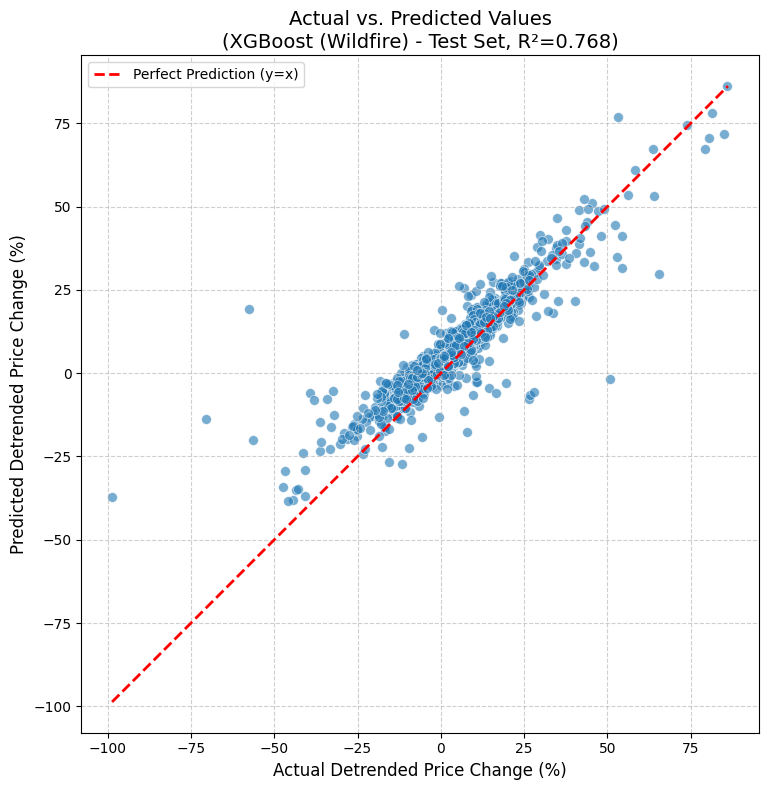

In [9]:
# Step 8: Actual vs. Predicted Plot
print("\n--- Plotting Actual vs. Predicted (XGBoost Wildfire Model) ---")

# Choose the model predictions you want to plot
model_name_to_plot = "XGBoost (Wildfire)"
y_pred_plot = predictions[model_name_to_plot]

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_plot, alpha=0.6, s=50) # s adjusts marker size

# Add the ideal y=x line
min_val = min(y_test.min(), y_pred_plot.min())
max_val = max(y_test.max(), y_pred_plot.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')

plt.xlabel("Actual Detrended Price Change (%)", fontsize=12)
plt.ylabel("Predicted Detrended Price Change (%)", fontsize=12)
plt.title(f"Actual vs. Predicted Values\n({model_name_to_plot} - Test Set, R²={results[model_name_to_plot]['R2']:.3f})", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box') # Make axes scales equal for a true 45-degree line
plt.tight_layout()
plt.show()


--- XGBoost (Wildfire) Feature Importances ---


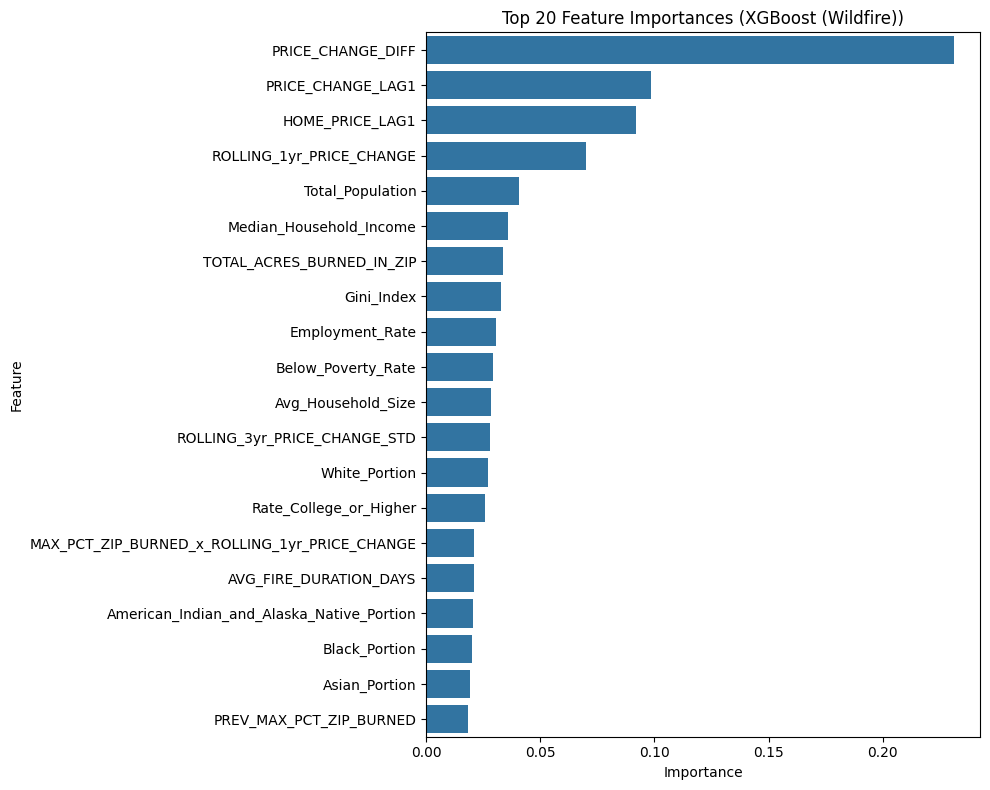


XGBoost (Wildfire) Importance Summary:
  Total importance of Wildfire-specific features: 0.1705
  Total importance of Baseline features: 0.8295


In [10]:
# Step 9: Feature Importance Plots (Tree-Based Models)
# --- XGBoost Feature Importance ---
model_to_analyze_xgb = "XGBoost (Wildfire)"
if model_to_analyze_xgb in models_to_evaluate:
    xgb_model_obj = models_to_evaluate[model_to_analyze_xgb][0]
    if hasattr(xgb_model_obj, 'feature_importances_'):
        print(f"\n--- {model_to_analyze_xgb} Feature Importances ---")
        importances_xgb = xgb_model_obj.feature_importances_
        feature_names_xgb = X_train_wf_scaled.columns # Get names from scaled training data
        feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names_xgb, 'Importance': importances_xgb})
        feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, 8)) # Adjust size
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df_xgb.head(20)) # Show top 20
        plt.title(f'Top 20 Feature Importances ({model_to_analyze_xgb})')
        plt.tight_layout()
        plt.show()

        # Importance sum check
        wildfire_importance_xgb = feature_importance_df_xgb[feature_importance_df_xgb['Feature'].isin(wildfire_features)]['Importance'].sum()
        baseline_importance_xgb = feature_importance_df_xgb[feature_importance_df_xgb['Feature'].isin(baseline_features)]['Importance'].sum()
        print(f"\n{model_to_analyze_xgb} Importance Summary:")
        print(f"  Total importance of Wildfire-specific features: {wildfire_importance_xgb:.4f}")
        print(f"  Total importance of Baseline features: {baseline_importance_xgb:.4f}")
    else:
        print(f"Model '{model_to_analyze_xgb}' does not have 'feature_importances_' attribute.")
else:
    print(f"Model '{model_to_analyze_xgb}' not found for importance analysis.")